In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_excel("newdata.xlsx")

In [3]:
# Data Cleaning
# Normalize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Drop duplicates
df.drop_duplicates(inplace=True)

# Handle missing values in relevant columns
df['log_profit'] = np.log1p(df['profit'])  # Recalculate log_profit
df['log_profit'].fillna(df['log_profit'].median(), inplace=True)  # Impute missing values with the median

# Ensure date columns are in datetime format
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['ship_date'] = pd.to_datetime(df['ship_date'], errors='coerce')

C:\Users\rohai\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
# Feature Engineering
# Log Transformation for skewed data
df['log_sales'] = np.log1p(df['sales'])

# Aggregations: Monthly Sales
df['monthly_sales'] = df.groupby(pd.Grouper(key='order_date', freq='M'))['sales'].transform('sum')

# Interaction Terms: Revenue (Price * Quantity)
df['revenue'] = df['sales'] * df['quantity']

# Date Features
df['month'] = df['order_date'].dt.month
df['year'] = df['order_date'].dt.year
df['day_of_week'] = df['order_date'].dt.day_name()

# Create a Holiday Flag (example holidays)
holiday_dates = ['2016-12-25', '2016-11-24', '2017-12-25', '2017-11-23']
df['holiday_flag'] = df['order_date'].isin(pd.to_datetime(holiday_dates)).astype(int)

# Profit Margin (handling division by zero)
df['profit_margin'] = df['profit'] / df['sales'].replace(0, np.nan)

# Purchase Frequency
df['purchase_frequency'] = df.groupby('customer_id')['order_id'].transform('count')

# Discounted Quantity (interaction feature)
df['discounted_quantity'] = df['discount'] * df['quantity']

In [5]:
# Model Building
# Define features and target
features = ['revenue', 'log_sales', 'log_profit', 'monthly_sales', 
            'profit_margin', 'discounted_quantity', 'holiday_flag']
target = 'sales'

X = df[features]
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Root Mean Squared Error (RMSE): 244.0032039488738
R-squared: 0.8992083156940601


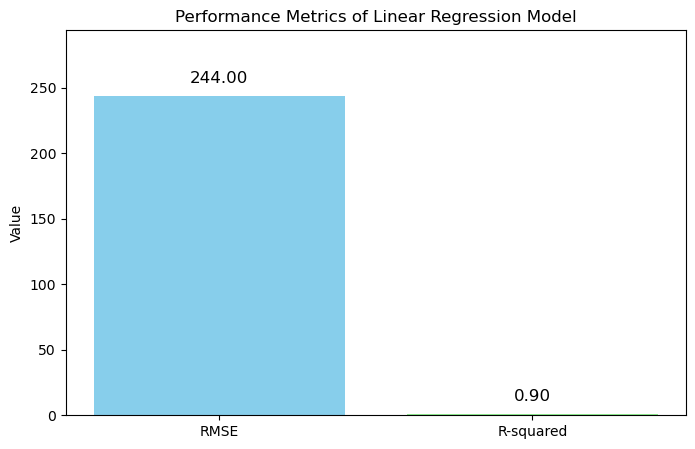

In [21]:
# Model Evaluation
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

# Bar chart
metrics = ['RMSE', 'R-squared']
values = [rmse, r2]

# Create the bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['skyblue', 'lightgreen'])

# Add labels and title
plt.title("Performance Metrics of Linear Regression Model")
plt.ylabel("Value")
plt.ylim(0, max(values) + 50)  # Add padding for better visualization

# Annotate the bars with the exact values
for i, v in enumerate(values):
    plt.text(i, v + 10, f"{v:.2f}", ha='center', fontsize=12)

# Show the plot
plt.show()

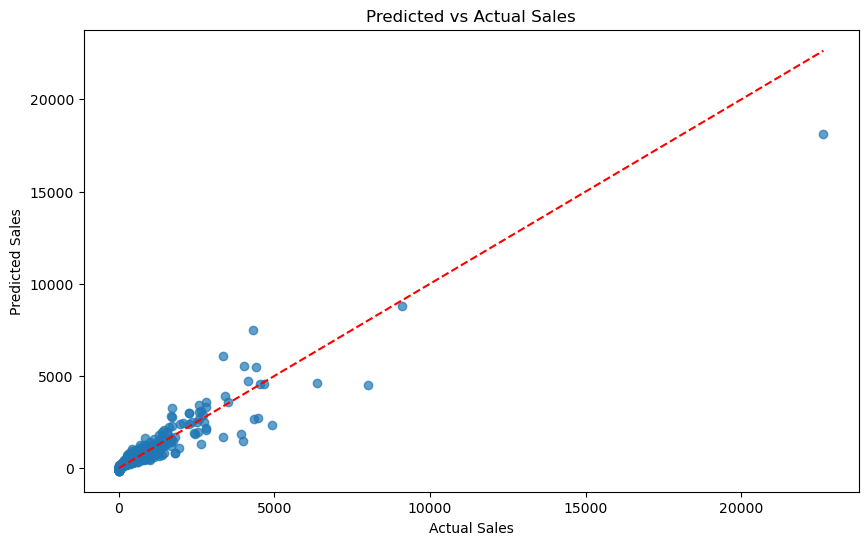

In [8]:
# Visualization
# Predicted vs Actual Sales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Predicted vs Actual Sales")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.show()

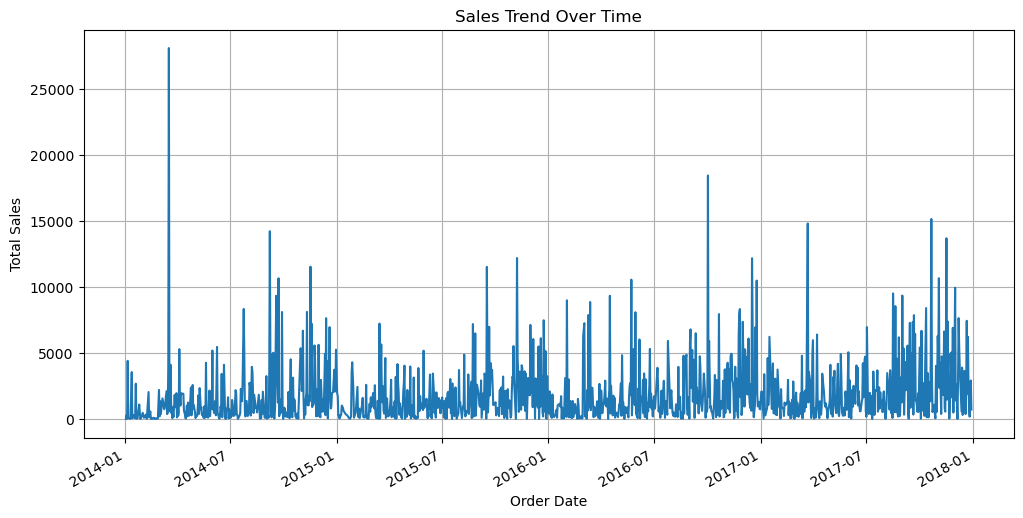

In [22]:
# Sales Trend Over Time
plt.figure(figsize=(12, 6))
df.groupby('order_date')['sales'].sum().plot()
plt.title("Sales Trend Over Time")
plt.xlabel("Order Date")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()

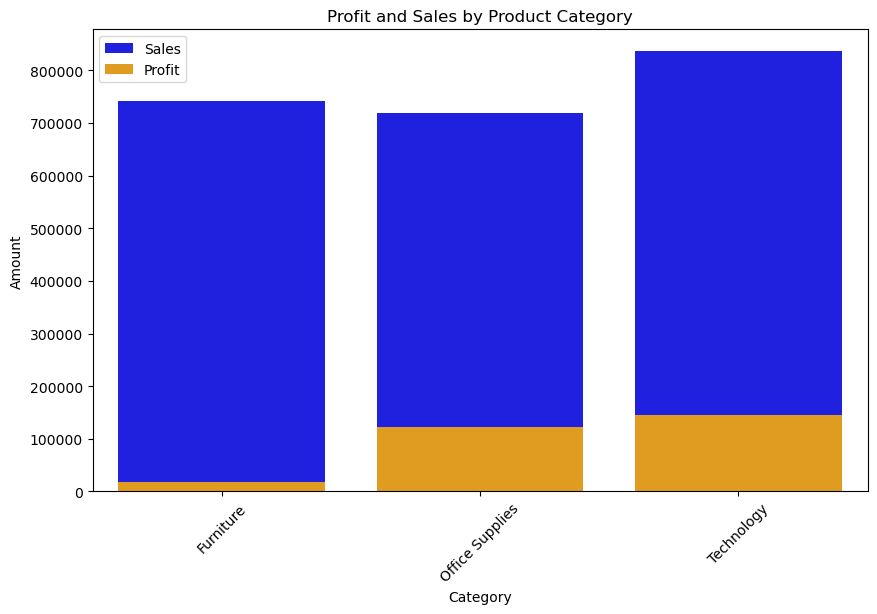

In [10]:
# Profit and Sales by Product Category
category_summary = df.groupby('category')[['sales', 'profit']].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='category', y='sales', data=category_summary, color='blue', label='Sales')
sns.barplot(x='category', y='profit', data=category_summary, color='orange', label='Profit')
plt.title("Profit and Sales by Product Category")
plt.xlabel("Category")
plt.ylabel("Amount")
plt.legend()
plt.xticks(rotation=45)
plt.show()

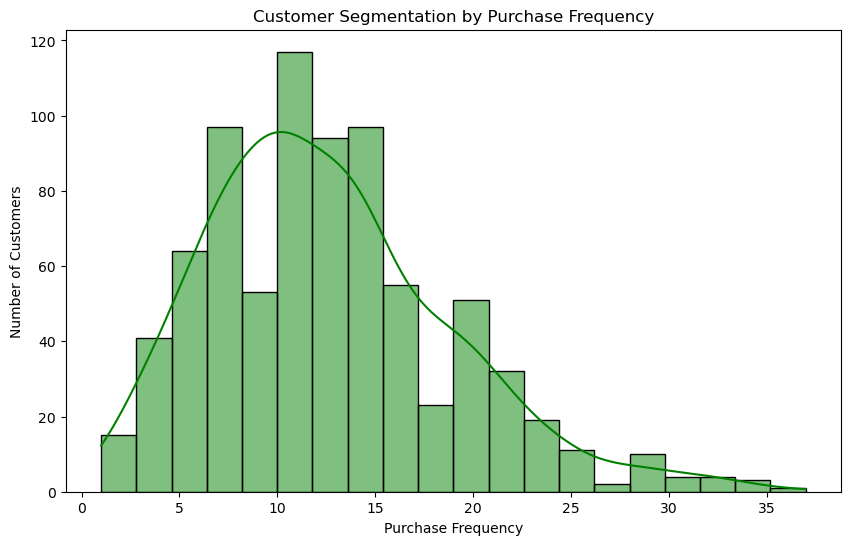

In [12]:
# Customer Segmentation by Purchase Frequency
customer_summary = df.groupby('customer_id')['purchase_frequency'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.histplot(customer_summary['purchase_frequency'], bins=20, kde=True, color='green')
plt.title("Customer Segmentation by Purchase Frequency")
plt.xlabel("Purchase Frequency")
plt.ylabel("Number of Customers")
plt.show()

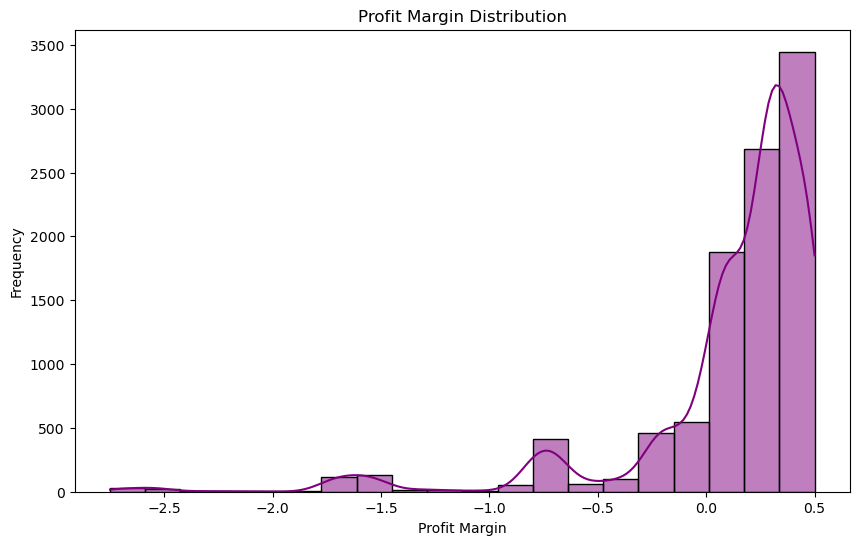

In [13]:
# Profit Margin Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['profit_margin'], bins=20, kde=True, color='purple')
plt.title("Profit Margin Distribution")
plt.xlabel("Profit Margin")
plt.ylabel("Frequency")
plt.show()

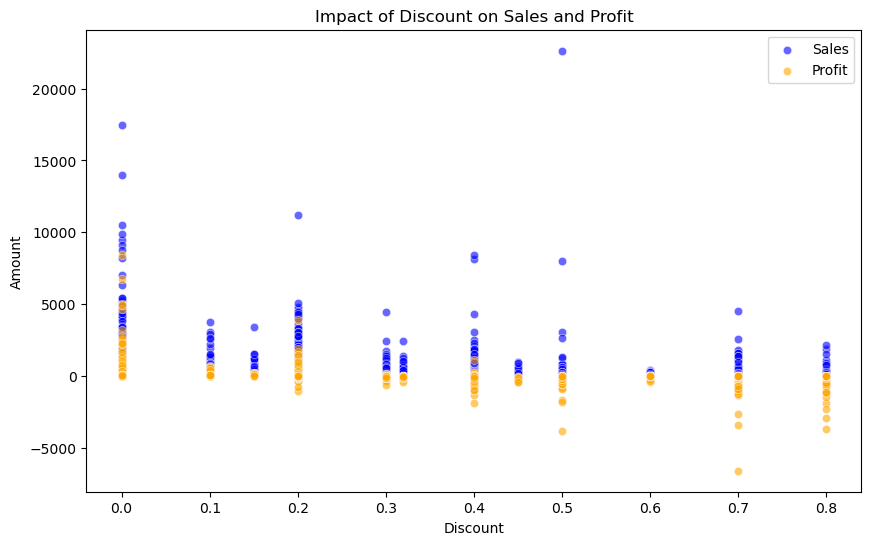

In [14]:
# Impact of Discount on Sales and Profit
plt.figure(figsize=(10, 6))
sns.scatterplot(x='discount', y='sales', data=df, label='Sales', alpha=0.6, color='blue')
sns.scatterplot(x='discount', y='profit', data=df, label='Profit', alpha=0.6, color='orange')
plt.title("Impact of Discount on Sales and Profit")
plt.xlabel("Discount")
plt.ylabel("Amount")
plt.legend()
plt.show()

Sales by Holiday Flag:
holiday_flag
0    2.276466e+06
1    2.073463e+04
Name: sales, dtype: float64


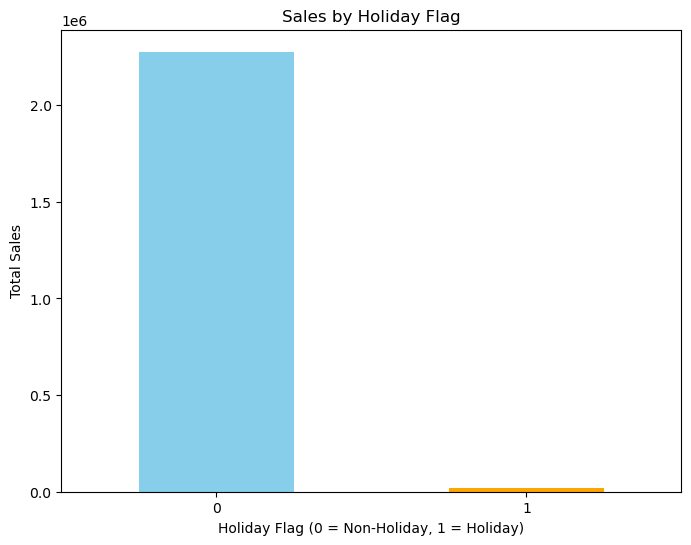

In [17]:
# Check total sales for holiday and non-holiday periods
sales_by_holiday = df.groupby('holiday_flag')['sales'].sum()

print("Sales by Holiday Flag:")
print(sales_by_holiday)

plt.figure(figsize=(8, 6))
sales_by_holiday.plot(kind='bar', color=['skyblue', 'orange'])
plt.title("Sales by Holiday Flag")
plt.xlabel("Holiday Flag (0 = Non-Holiday, 1 = Holiday)")
plt.ylabel("Total Sales")
plt.xticks(rotation=0)
plt.show()